In [60]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [61]:
def nndsvd_initialization(A, rank):

    u, s, v = np.linalg.svd(A, full_matrices=False)
    v = v.T
    w = np.zeros((A.shape[0], rank))
    h = np.zeros((rank, A.shape[1]))

    w[:, 0] = np.sqrt(s[0]) * np.abs(u[:, 0])
    h[0, :] = np.sqrt(s[0]) * np.abs(v[:, 0].T)

    for i in range(1, rank):
        ui = u[:, i]
        vi = v[:, i]
        ui_pos = (ui >= 0) * ui
        ui_neg = (ui < 0) * -ui
        vi_pos = (vi >= 0) * vi
        vi_neg = (vi < 0) * -vi

        ui_pos_norm = np.linalg.norm(ui_pos, 2)
        ui_neg_norm = np.linalg.norm(ui_neg, 2)
        vi_pos_norm = np.linalg.norm(vi_pos, 2)
        vi_neg_norm = np.linalg.norm(vi_neg, 2)

        norm_pos = ui_pos_norm * vi_pos_norm
        norm_neg = ui_neg_norm * vi_neg_norm

        if norm_pos >= norm_neg:
            w[:, i] = np.sqrt(s[i] * norm_pos) / ui_pos_norm * ui_pos
            h[i, :] = np.sqrt(s[i] * norm_pos) / vi_pos_norm * vi_pos.T
        else:
            w[:, i] = np.sqrt(s[i] * norm_neg) / ui_neg_norm * ui_neg
            h[i, :] = np.sqrt(s[i] * norm_neg) / vi_neg_norm * vi_neg.T

    return w, h



def divergence(V,W,H):
    return np.sum(V * np.log((V) / (W @ H)) - V + W @ H)


def NMF(V, S, threshold = 0.000005, MAXITER = 10000): 

    counter = 0
    cost_function = []
    beta_divergence = 1
    
    W, H = nndsvd_initialization(V, S)

    while beta_divergence >= threshold and counter <= MAXITER:
        
        H *= (W.T @ V) / (W.T @ (W @ H) + 10e-10)
        H[H < 0] = 0
        W *= (V @ H.T) / ((W @ H) @ H.T + 10e-10)
        W[W < 0] = 0
        
        beta_divergence =  divergence(V, W, H)
        cost_function.append(beta_divergence)
        counter += 1

    return W, H


In [62]:
FRAME1 = 1024
HOP = 512

In [71]:
audio_file = "../data/micro2.mp3"
y, sr = librosa.load(audio_file)
D = librosa.stft(y, n_fft=FRAME1, hop_length=HOP)
magnitude = np.abs(D) 
ipd.Audio(y, rate = sr)

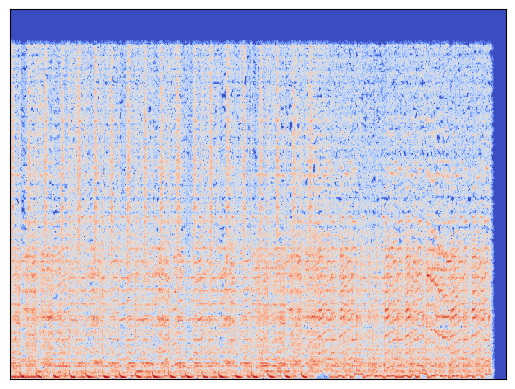

In [72]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude), sr=sr, n_fft=FRAME1, hop_length=HOP)

In [65]:
# W, H = NMF(magnitude, 2)
from sklearn.decomposition import NMF
model = NMF(n_components = 2, init='nndsvd', random_state=0, max_iter= 100000000000000000000000, l1_ratio=0.000000000001)
W = model.fit_transform(magnitude)
H = model.components_

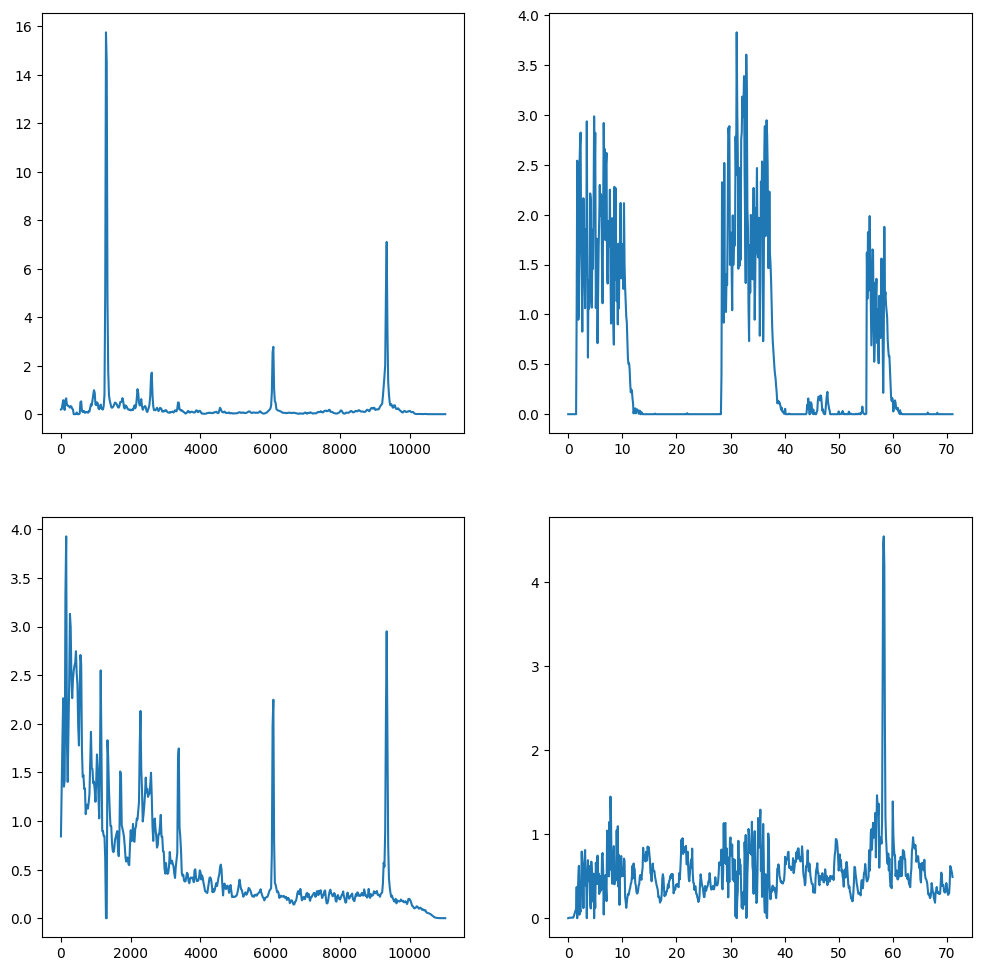

In [66]:
dims = np.shape(magnitude)
rows = dims[0]
cols = dims[1]
f, axs = plt.subplots(2, 2, figsize=(12,12))
axs[0,0].set_title = "W"
axs[0,1].set_title = "H"
for row in range(2):
    axs[row,0].plot(np.linspace(0, 11025,rows),W[:,row])
    axs[row,1].plot(np.linspace(0, 71,cols),H[row])
    

In [67]:
sound_stft_A = np.angle(D)
filters = [1]
filtered = W[:,filters]@H[filters,:]
reconst = filtered * np.exp(1j*sound_stft_A)
new_sound = librosa.istft(reconst, n_fft=FRAME1, hop_length=HOP)

In [68]:
ipd.Audio(new_sound, rate=sr)